In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [3]:
import pandas as pd
import numpy as np

In [4]:
mlde_all = pd.read_csv("results/mlde/vis_5/all_df.csv")

In [5]:
mlde_all.columns

Index(['encoding', 'model', 'n_sample', 'ft_lib', 'rep', 'all_maxes',
       'all_means', 'top_maxes', 'top_means', 'ndcgs', 'rhos', 'if_truemaxs',
       'truemax_inds', 'n_mut_cutoff', 'lib', 'zs', 'n_top', 'scale_fit'],
      dtype='object')

In [15]:
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.zs_analysis import ZS_OPTS_LEGEND
from SSMuLA.vis import ZS_COLOR_MAP, PRESENTATION_PALETTE_SATURATE

In [7]:
mlde_df = mlde_all[(mlde_all["encoding"] == "one-hot") & (mlde_all["n_sample"] == 384) & (mlde_all["n_top"] == 96)].copy()
mlde_df

,encoding,model,n_sample,ft_lib,rep,all_maxes,all_means,top_maxes,top_means,ndcgs,rhos,if_truemaxs,truemax_inds,n_mut_cutoff,lib,zs,n_top,scale_fit
12600,one-hot,boosting,384,4000,0,0.837839,0.160675,0.982530,0.582432,0.931561,0.512189,0.0,178.0,all,DHFR,Triad_score,96,max
12601,one-hot,boosting,384,4000,1,0.835335,0.163866,1.000000,0.541919,0.919135,0.520578,1.0,22.0,all,DHFR,Triad_score,96,max
12602,one-hot,boosting,384,4000,2,0.839829,0.157905,0.969296,0.435451,0.894345,0.528852,0.0,363.0,all,DHFR,Triad_score,96,max
12603,one-hot,boosting,384,4000,3,0.811491,0.171549,0.865538,0.565615,0.917335,0.499166,0.0,367.0,all,DHFR,Triad_score,96,max
12604,one-hot,boosting,384,4000,4,0.839540,0.174150,0.996537,0.559871,0.911455,0.507032,0.0,101.0,all,DHFR,Triad_score,96,max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812995,one-hot,ridge,384,20000,95,0.396813,-0.005601,0.724265,0.386423,0.984413,0.227208,0.0,2244.0,all,TrpB4,structnmsa-comb_score,96,max
1812996,one-hot,ridge,384,20000,96,0.450992,-0.011725,0.696237,0.268654,0.983545,0.230354,0.0,452.0,all,TrpB4,structnmsa-comb_score,96,max
1812997,one-hot,ridge,384,20000,97,0.430895,-0.041899,0.800478,0.290288,0.985826,0.224715,0.0,1336.0,all,TrpB4,structnmsa-comb_score,96,max
1812998,one-hot,ridge,384,20000,98,0.454781,-0.028003,0.559561,0.242864,0.983619,0.229553,0.0,2632.0,all,TrpB4,structnmsa-comb_score,96,max


In [8]:
def get_val_frac(s: pd.Series, numb: float = 1) -> float:
    """
    Get the fraction of a column that is equal to a certain number.
    """
    return (s == numb).sum() / len(s)

In [9]:
all_calc_df_list = []
ft_lib_frac_list = [0.125, 0.25, 0.5, 1]

for lib in LIB_INFO_DICT.keys():
    # get double
    hm2_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "double") & (mlde_df["zs"] == "none")]

    append_hm_df = pd.DataFrame({
        "lib": [lib] * len(ft_lib_frac_list),
        "zs": ["hm2"] * len(ft_lib_frac_list),
        "ft_lib": ft_lib_frac_list,
        "mean": [hm2_df["top_maxes"].mean()] * len(ft_lib_frac_list),
        "frac": [get_val_frac(hm2_df["top_maxes"])] * len(ft_lib_frac_list)
    })

    append_zs = deepcopy(ZS_OPTS_LEGEND)
    append_zs["hm2"] = "Hamming distance ≤ 2"

    # get no zs
    nozs_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "all") & (mlde_df["zs"] == "none")]

    append_df = pd.concat([
        append_hm_df, 
        pd.DataFrame({
        "lib": [lib] * len(ft_lib_frac_list),
        "zs": ["none"] * len(ft_lib_frac_list),
        "ft_lib": ft_lib_frac_list,
        "mean": [nozs_df["top_maxes"].mean()] * len(ft_lib_frac_list),
        "frac": [get_val_frac(nozs_df["top_maxes"])] * len(ft_lib_frac_list)
    })
    ]
    )

    # get mean for the rest
    lib_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "all")][["lib", "zs", "ft_lib", "top_maxes"]]

    # map ft_lib size 
    lib_df['ft_lib'] = lib_df['ft_lib'].map({numb: frac for numb, frac in zip(sorted(lib_df["ft_lib"].unique()), ft_lib_frac_list)})

    all_calc_df_list.append(pd.concat([
        append_df,
        lib_df.groupby(["lib", "zs", "ft_lib"])["top_maxes"].agg(
            ["mean", get_val_frac]
        ).rename(columns={"get_val_frac": "frac"}).reset_index()
    ]).reset_index(drop=True))

all_calc_df = pd.concat(all_calc_df_list).reset_index(drop=True)
all_calc_df["zs"] = all_calc_df["zs"].map(append_zs)
all_calc_df["type"] = all_calc_df["lib"].map({n:v["type"] for n, v in LIB_INFO_DICT.items()})
all_calc_df

,lib,zs,ft_lib,mean,frac,type
0,DHFR,Hamming distance ≤ 2,0.125,0.988583,0.785,Enzymatic activity
1,DHFR,Hamming distance ≤ 2,0.250,0.988583,0.785,Enzymatic activity
2,DHFR,Hamming distance ≤ 2,0.500,0.988583,0.785,Enzymatic activity
3,DHFR,Hamming distance ≤ 2,1.000,0.988583,0.785,Enzymatic activity
4,DHFR,Random,0.125,0.948174,0.465,Enzymatic activity
...,...,...,...,...,...,...
457,TrpB4,Triad + ESM-IF,0.250,0.798587,0.160,Enzymatic activity
458,TrpB4,Triad + ESM-IF,0.500,0.786662,0.060,Enzymatic activity
459,TrpB4,Triad + EVMutation + ESM + ESM-IF,0.125,0.830250,0.230,Enzymatic activity
460,TrpB4,Triad + EVMutation + ESM + ESM-IF,0.250,0.822917,0.145,Enzymatic activity


In [103]:
ZS_COLOR_MAP

{'none': '#666666',
 'Triad_score': '#4bacc6',
 'ev_score': '#9bbb59',
 'esm_score': '#8064a2',
 'esmif_score': '#f79646ff',
 'struc-comb_score': '#849895',
 'msanoif-comb_score': '#9DAE88',
 'msa-comb_score': '#F1D384',
 'structnmsa-comb_score': '#C7B784'}

In [94]:
color_map = deepcopy(ZS_COLOR_MAP)
color_map["hm2"] =PRESENTATION_PALETTE_SATURATE["yellow"]

In [93]:
append_zs

{'none': 'Random',
 'Triad_score': 'Triad',
 'ev_score': 'EVMutation',
 'esm_score': 'ESM',
 'esmif_score': 'ESM-IF',
 'struc-comb_score': 'Triad + ESM-IF',
 'msanoif-comb_score': 'EVMutation + ESM',
 'msa-comb_score': 'EVMutation + ESM + ESM-IF',
 'structnmsa-comb_score': 'Triad + EVMutation + ESM + ESM-IF',
 'hm2': 'Hamming distance ≤ 2'}

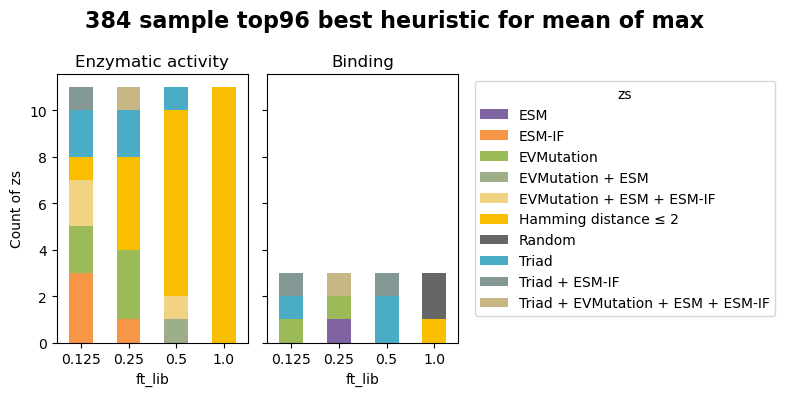

In [118]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['mean'].idxmax()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 best heuristic for mean of max", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

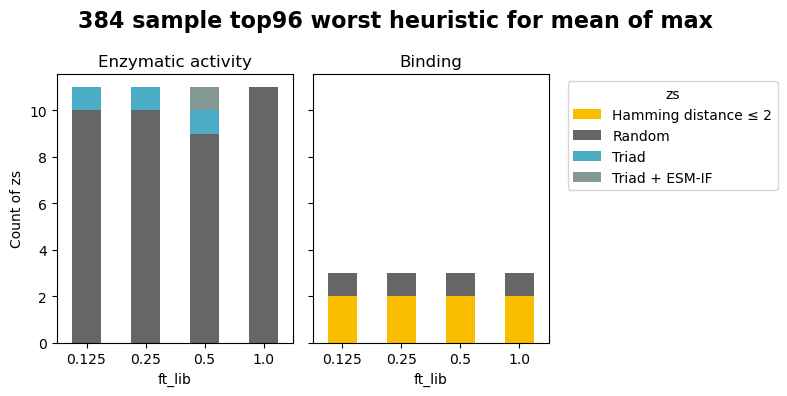

In [119]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['mean'].idxmin()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 worst heuristic for mean of max", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

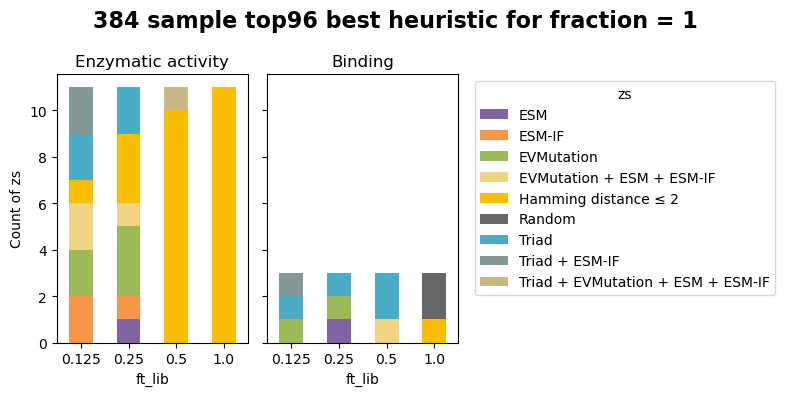

In [120]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['frac'].idxmax()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 best heuristic for fraction = 1", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

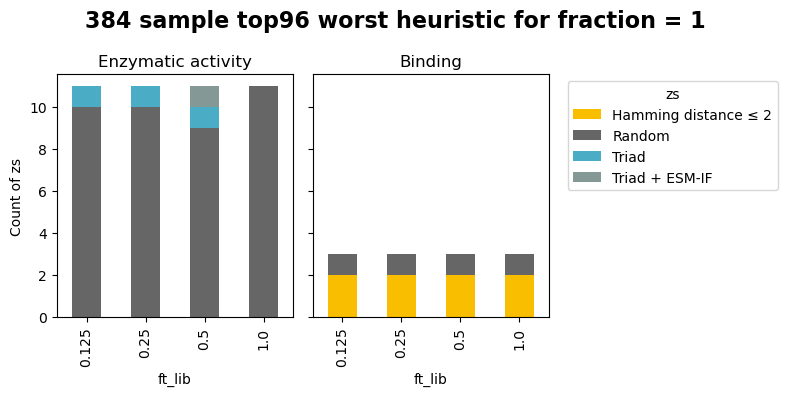

In [121]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['frac'].idxmin()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 worst heuristic for fraction = 1", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

In [11]:
from SSMuLA.zs_analysis import ZS_OPTS

In [28]:
# now do not use essenble
mlde_df = mlde_all[(mlde_all["encoding"] == "one-hot") & (mlde_all["n_sample"] == 384) & (mlde_all["n_top"] == 96) & (mlde_all["zs"].isin(["none"] + ZS_OPTS))].copy()
mlde_df

,encoding,model,n_sample,ft_lib,rep,all_maxes,all_means,top_maxes,top_means,ndcgs,rhos,if_truemaxs,truemax_inds,n_mut_cutoff,lib,zs,n_top,scale_fit
12600,one-hot,boosting,384,4000,0,0.837839,0.160675,0.982530,0.582432,0.931561,0.512189,0.0,178.0,all,DHFR,Triad_score,96,max
12601,one-hot,boosting,384,4000,1,0.835335,0.163866,1.000000,0.541919,0.919135,0.520578,1.0,22.0,all,DHFR,Triad_score,96,max
12602,one-hot,boosting,384,4000,2,0.839829,0.157905,0.969296,0.435451,0.894345,0.528852,0.0,363.0,all,DHFR,Triad_score,96,max
12603,one-hot,boosting,384,4000,3,0.811491,0.171549,0.865538,0.565615,0.917335,0.499166,0.0,367.0,all,DHFR,Triad_score,96,max
12604,one-hot,boosting,384,4000,4,0.839540,0.174150,0.996537,0.559871,0.911455,0.507032,0.0,101.0,all,DHFR,Triad_score,96,max
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630995,one-hot,ridge,384,77,95,0.771698,0.017581,0.749107,0.330329,0.979702,0.190245,0.0,18712.0,single,TrpB4,none,96,max
1630996,one-hot,ridge,384,77,96,0.597178,0.060315,0.749107,0.361424,0.980491,0.190741,0.0,8115.0,single,TrpB4,none,96,max
1630997,one-hot,ridge,384,77,97,0.634966,0.009730,0.752895,0.428029,0.981345,0.193477,0.0,14961.0,single,TrpB4,none,96,max
1630998,one-hot,ridge,384,77,98,0.783760,0.040222,0.749107,0.284615,0.979312,0.188739,0.0,7419.0,single,TrpB4,none,96,max


In [29]:
de_folder = "results/de/DE-active/scale2max"
liborderby = "single_step_DE"

de_sumdf = pd.read_csv(f"{de_folder}/all_landscape_de_summary.csv")
liborder = list(
    de_sumdf[de_sumdf["de_type"] == liborderby]
    .sort_values(by=["mean_all"])["lib"]
    .values
)
ft_lib_frac_list = [0.125, 0.25, 0.5, 1]

In [23]:
%matplotlib inline

In [31]:
from matplotlib.lines import Line2D

14it [00:00, 30.27it/s]


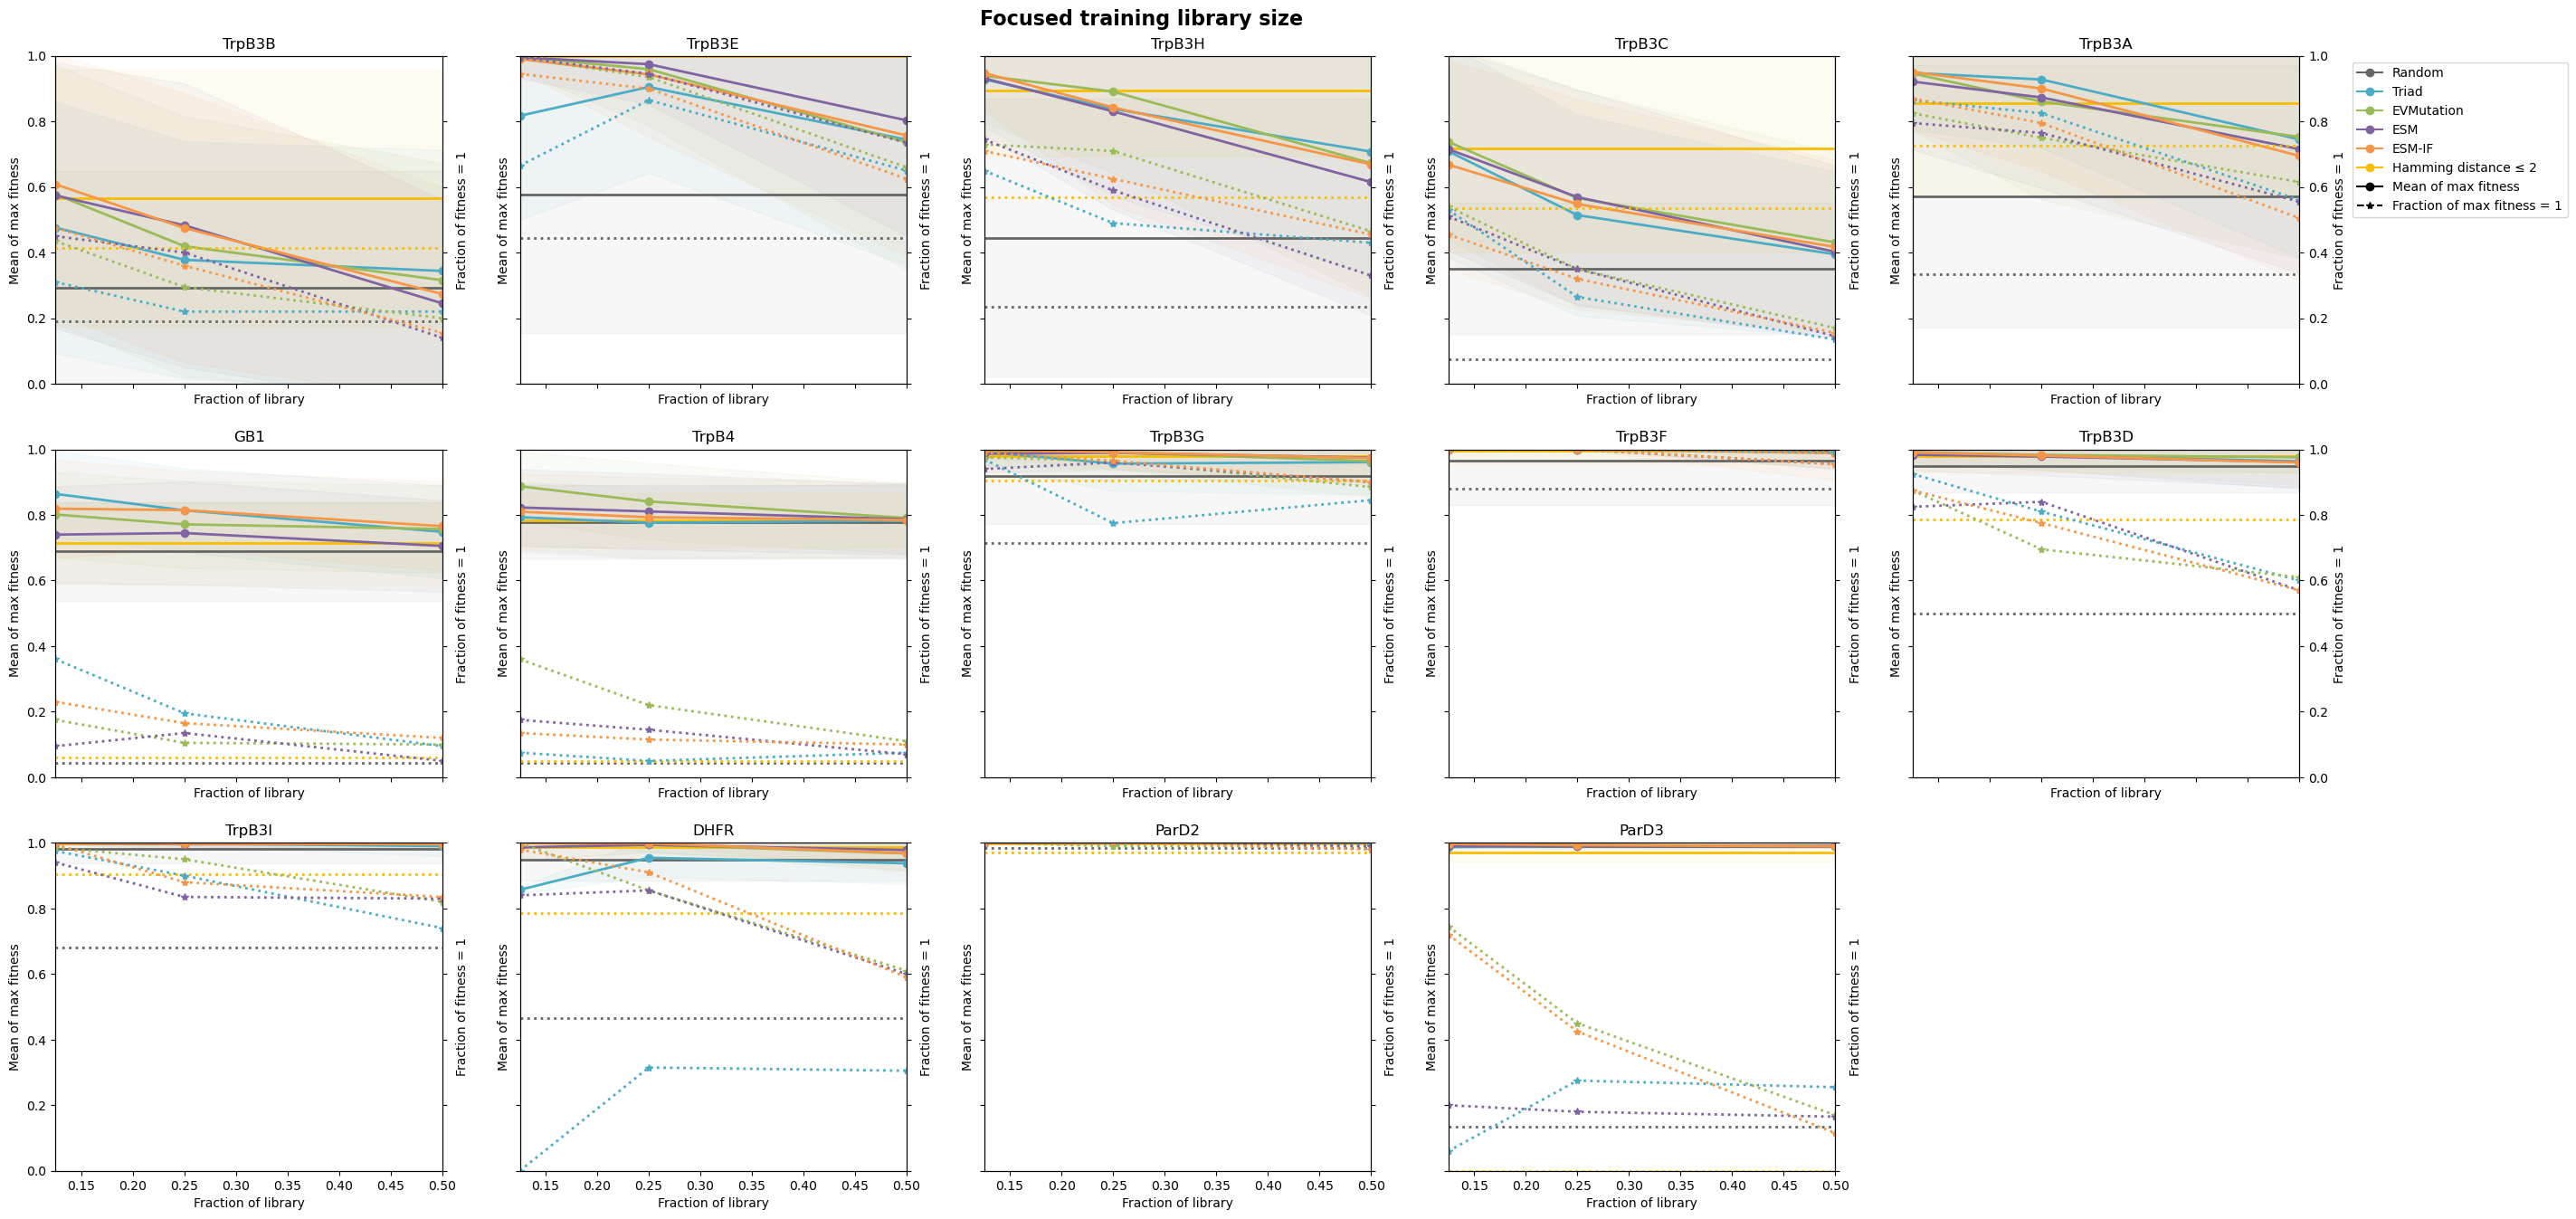

In [34]:
sup_title = "Focused training library size"

ncol = 5
nrow = 3

fig, axs = plt.subplots(nrow, ncol, figsize=(32, 16), sharex=True, sharey=True)
frac_axs = []

for ax in axs.flatten():
    frac_axs.append(ax.twinx())

for i, (ax, frac_ax, lib) in tqdm(enumerate(zip(axs.flatten(), frac_axs, liborder))):
    # each subplot is a library with x axis as ft_lib and y axis as mean of top_maxes for each zs
    lib_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "all")].copy()
    lib_df["ft_lib"] = lib_df["ft_lib"].map({numb: frac for numb, frac in zip(sorted(lib_df["ft_lib"].unique()), ft_lib_frac_list)})
    # plot all none zs as a line
    rand_df = lib_df[lib_df["zs"] == "none"].copy()
    rand_mean = [rand_df["top_maxes"].mean()] * len(ft_lib_frac_list)
    rand_std = [rand_df["top_maxes"].std()] * len(ft_lib_frac_list)
    rand_frac = [get_val_frac(rand_df["top_maxes"])] * len(ft_lib_frac_list)
    ax.plot(ft_lib_frac_list, rand_mean, color=PRESENTATION_PALETTE_SATURATE["gray"], linestyle="solid", linewidth=2)
    ax.fill_between(ft_lib_frac_list, np.array(rand_mean) - np.array(rand_std), np.array(rand_mean) + np.array(rand_std), color=PRESENTATION_PALETTE_SATURATE["gray"], alpha=0.05)
    frac_ax.plot(ft_lib_frac_list, rand_frac, color=PRESENTATION_PALETTE_SATURATE["gray"], linestyle="dotted", linewidth=2)

    # plot double none zs as a line
    hm2_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "double") & (mlde_df["zs"] == "none")]
    hm2_mean = [hm2_df["top_maxes"].mean()] * len(ft_lib_frac_list)
    hm2_std = [hm2_df["top_maxes"].std()] * len(ft_lib_frac_list)
    hm2_frac = [get_val_frac(hm2_df["top_maxes"])] * len(ft_lib_frac_list)
    ax.plot(ft_lib_frac_list, hm2_mean, color=PRESENTATION_PALETTE_SATURATE["yellow"], linestyle="solid", linewidth=2)
    ax.fill_between(ft_lib_frac_list, np.array(hm2_mean) - np.array(hm2_std), np.array(hm2_mean) + np.array(hm2_std), color=PRESENTATION_PALETTE_SATURATE["yellow"], alpha=0.05)
    frac_ax.plot(ft_lib_frac_list, hm2_frac, color=PRESENTATION_PALETTE_SATURATE["yellow"], linestyle="dotted", linewidth=2)

    for zs in ZS_OPTS:
        zs_df = lib_df[lib_df["zs"] == zs].copy()
        zs_mean = zs_df.groupby("ft_lib")["top_maxes"].mean()
        zs_std = zs_df.groupby("ft_lib")["top_maxes"].std()
        zs_frac = zs_df.groupby("ft_lib")["top_maxes"].apply(get_val_frac)
        ax.plot(zs_mean.index, zs_mean, label=zs, color=ZS_COLOR_MAP[zs], marker="o", linestyle="solid", linewidth=2)
        ax.fill_between(zs_mean.index, zs_mean - zs_std, zs_mean + zs_std, color=ZS_COLOR_MAP[zs], alpha=0.05)
        frac_ax.plot(zs_frac.index, zs_frac, label=zs, color=ZS_COLOR_MAP[zs], marker="*", linestyle="dotted", linewidth=2)

    ax.set_title(lib)
    ax.set_xlabel("Fraction of library")
    ax.set_ylabel("Mean of max fitness")
    frac_ax.set_ylabel("Fraction of fitness = 1")
    
    # cut off the last one
    ax.set_xlim(0.125, 0.5)
    ax.set_ylim(0, 1)
    frac_ax.set_xlim(0.125, 0.5)
    frac_ax.set_ylim(0, 1)

    if i % ncol != ncol - 1:
        frac_ax.set_yticklabels([])

    if i == ncol - 1:
        # create labels
        legend_list = []
        for zs in ["none"] + ZS_OPTS:
            legend_list.append(
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    linestyle="solid",
                    color=ZS_COLOR_MAP[zs],
                    label=ZS_OPTS_LEGEND[zs],
                )
            )

        # add double
        legend_list.append(
            Line2D(
                [0],
                [0],
                marker="o",
                linestyle="solid",
                color=PRESENTATION_PALETTE_SATURATE["yellow"],
                label="Hamming distance ≤ 2",
            )
        )

        # add frac
        legend_list.append(
            Line2D([0], [0], color="black", marker="o",
            linestyle="solid", label="Mean of max fitness")
        )
        legend_list.append(
            Line2D([0], [0], color="black", marker="*",
            linestyle="dashed", label="Fraction of max fitness = 1")
        )

        ax.legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1.12, 1))

    ax.set_title(lib)

extra_len = len(axs.flatten()) - len(liborder)

if extra_len > 0:
    for i in range(extra_len):
        axs.flatten()[-(i + 1)].set_visible(False)
        frac_axs[-(i + 1)].set_visible(False)

fig.tight_layout
fig.suptitle(sup_title, fontsize=16, fontweight="bold", y=0.9125)

plt.show()

In [13]:
all_calc_df_list = []
ft_lib_frac_list = [0.125, 0.25, 0.5, 1]

for lib in LIB_INFO_DICT.keys():
    # get double
    hm2_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "double") & (mlde_df["zs"] == "none")]

    append_hm_df = pd.DataFrame({
        "lib": [lib] * len(ft_lib_frac_list),
        "zs": ["hm2"] * len(ft_lib_frac_list),
        "ft_lib": ft_lib_frac_list,
        "mean": [hm2_df["top_maxes"].mean()] * len(ft_lib_frac_list),
        "frac": [get_val_frac(hm2_df["top_maxes"])] * len(ft_lib_frac_list)
    })

    append_zs = deepcopy(ZS_OPTS_LEGEND)
    append_zs["hm2"] = "Hamming distance ≤ 2"

    # get no zs
    nozs_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "all") & (mlde_df["zs"] == "none")]

    append_df = pd.concat([
        append_hm_df, 
        pd.DataFrame({
        "lib": [lib] * len(ft_lib_frac_list),
        "zs": ["none"] * len(ft_lib_frac_list),
        "ft_lib": ft_lib_frac_list,
        "mean": [nozs_df["top_maxes"].mean()] * len(ft_lib_frac_list),
        "frac": [get_val_frac(nozs_df["top_maxes"])] * len(ft_lib_frac_list)
    })
    ]
    )

    # get mean for the rest
    lib_df = mlde_df[(mlde_df["lib"] == lib) & (mlde_df["n_mut_cutoff"] == "all")][["lib", "zs", "ft_lib", "top_maxes"]]

    # map ft_lib size 
    lib_df['ft_lib'] = lib_df['ft_lib'].map({numb: frac for numb, frac in zip(sorted(lib_df["ft_lib"].unique()), ft_lib_frac_list)})

    all_calc_df_list.append(pd.concat([
        append_df,
        lib_df.groupby(["lib", "zs", "ft_lib"])["top_maxes"].agg(
            ["mean", get_val_frac]
        ).rename(columns={"get_val_frac": "frac"}).reset_index()
    ]).reset_index(drop=True))

all_calc_df = pd.concat(all_calc_df_list).reset_index(drop=True)
all_calc_df["zs"] = all_calc_df["zs"].map(append_zs)
all_calc_df["type"] = all_calc_df["lib"].map({n:v["type"] for n, v in LIB_INFO_DICT.items()})
all_calc_df

,lib,zs,ft_lib,mean,frac,type
0,DHFR,Hamming distance ≤ 2,0.125,0.988583,0.785,Enzymatic activity
1,DHFR,Hamming distance ≤ 2,0.250,0.988583,0.785,Enzymatic activity
2,DHFR,Hamming distance ≤ 2,0.500,0.988583,0.785,Enzymatic activity
3,DHFR,Hamming distance ≤ 2,1.000,0.988583,0.785,Enzymatic activity
4,DHFR,Random,0.125,0.948174,0.465,Enzymatic activity
...,...,...,...,...,...,...
289,TrpB4,ESM-IF,0.500,0.784780,0.100,Enzymatic activity
290,TrpB4,EVMutation,0.125,0.887387,0.360,Enzymatic activity
291,TrpB4,EVMutation,0.250,0.841140,0.220,Enzymatic activity
292,TrpB4,EVMutation,0.500,0.790776,0.110,Enzymatic activity


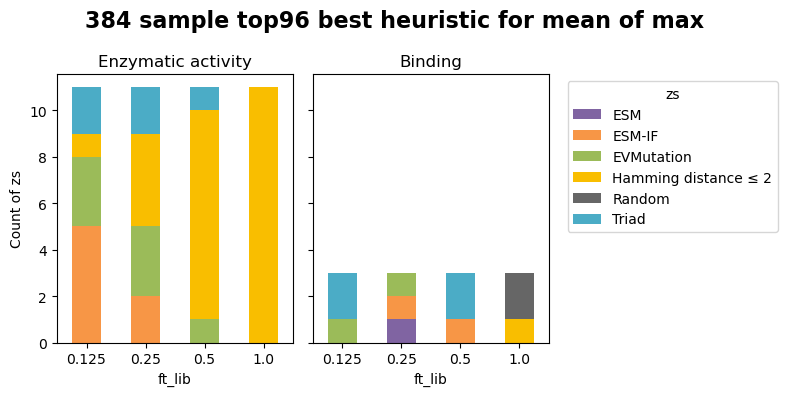

In [125]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['mean'].idxmax()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 best heuristic for mean of max", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

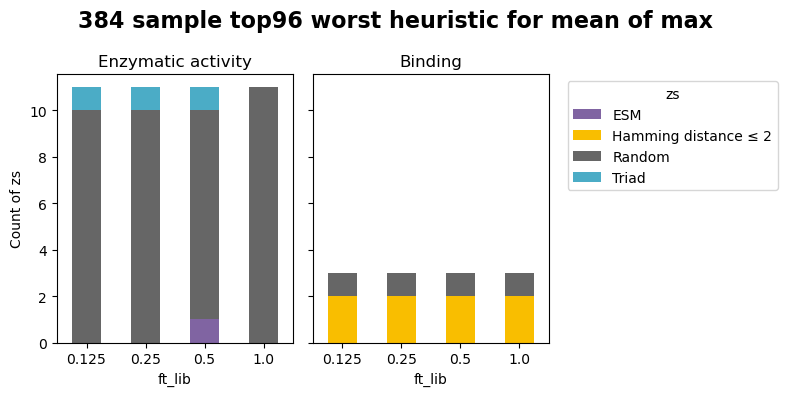

In [126]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['mean'].idxmin()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 worst heuristic for mean of max", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

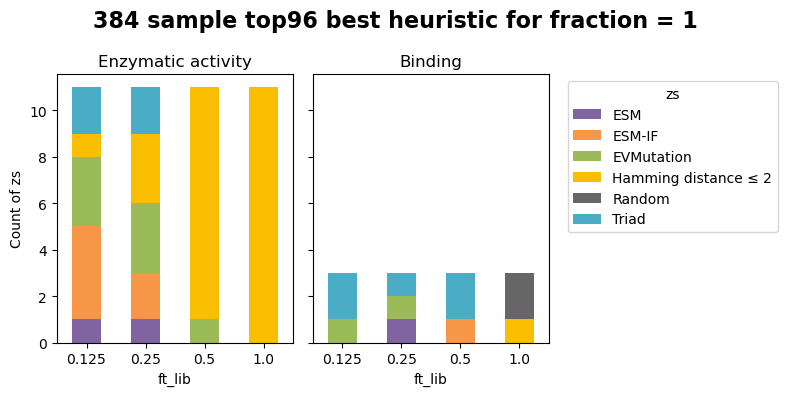

In [127]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['frac'].idxmax()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 best heuristic for fraction = 1", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()

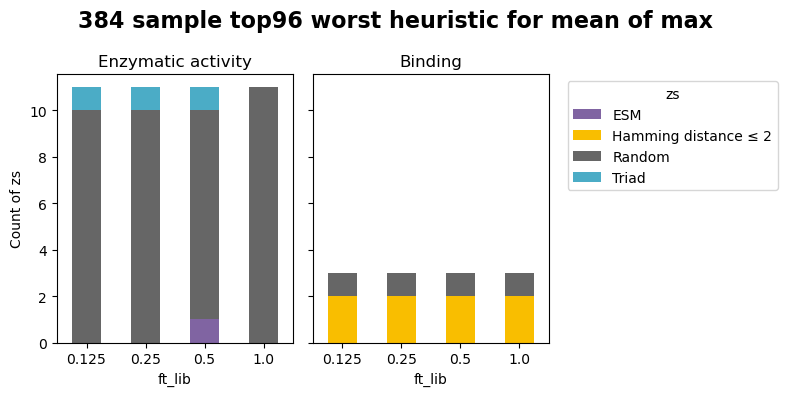

In [128]:
sliced_zs = all_calc_df.loc[all_calc_df.groupby(['lib', "ft_lib"])['frac'].idxmin()]

# Group by 'type', 'ft_lib', and 'zs' to get the counts
grouped = sliced_zs.groupby(['type', 'ft_lib', 'zs']).size().unstack(fill_value=0)

# Sort the counts
# sorted_grouped = grouped.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Create subplots for each type
types = sliced_zs['type'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(types), figsize=(8, 4), sharey=True)

# Plot stacked bar plots
for i, (ax, t) in enumerate(zip(axes, types)):
    group = grouped.loc[t]
    group.plot(kind='bar', stacked=True, ax=ax, color=[color_map[{v: k for k, v in append_zs.items()}[col]] for col in group.columns])
    ax.set_title(t)
    ax.set_xlabel('ft_lib')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    if i == 0:
        ax.set_ylabel('Count of zs')
        ax.legend().set_visible(False)
    else:
        ax.legend(title='zs', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle("384 sample top96 worst heuristic for mean of max", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.show()